# Data 620: Week 10 Assignment

Baron Curtin, Heather Geiger

## Introduction
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

In [2]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

Our dataset was taken from [Kaggle - SMS Spam Collection](https://www.kaggle.com/uciml/sms-spam-collection-dataset/download).
It is called the SMS Spam Collection dataset and it consists of 5,574 English SMS message that have been labelled "spam" or "ham".
The file contains one message per line. Each line is composed of two columns: the label, raw text.

## Data Loading
First we will load our data to begin building our Machine Learning Classifier.

In [3]:
data = pd.read_csv('./spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The last three columns are not useful to us and can safely be dropped

In [4]:
data = data.iloc[:,:2]

## Exploratory Data Analysis
We will do some basic exploratory analysis to understand our data a bit better

Text(0.5, 0, 'Label')

Text(0.5, 1.0, 'Spam vs Ham Messages')

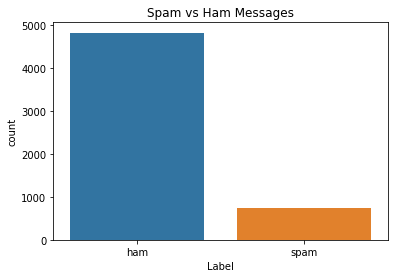

In [5]:
sns.countplot(data.v1)
plt.xlabel('Label')
plt.title('Spam vs Ham Messages')

ham     0.865937
spam    0.134063
Name: v1, dtype: float64

Text(0.5, 1.0, 'Spam vs Ham Messages 5')

Text(0.5, 0, 'Label')

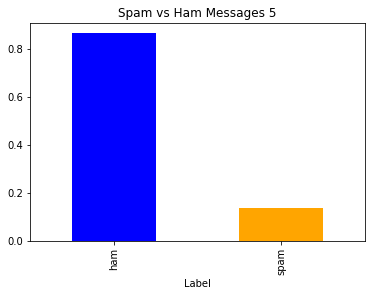

In [6]:
data.v1.value_counts(normalize=True)

data.v1.value_counts(normalize=True).plot(kind='bar', color=['blue','orange'])
plt.title('Spam vs Ham Messages 5')
plt.xlabel('Label')

We can see that spam messages comprise only ~13% of the dataset and ~87% represent "ham" messages. We can continue our
exploration by analyzing the frequency of words in each dataset

In [7]:
def join_n_split(series):
    return series.str.cat(sep=' ').split()

count_ham = Counter(join_n_split(data[data['v1'] == 'ham']['v2']))
count_spam = Counter(join_n_split(data[data['v1'] == 'spam']['v2']))

df_ham = pd.DataFrame.from_dict(count_ham, orient='index').reset_index()
df_ham.columns = ['word', 'ct']
df_ham['type'] = 'ham'
df_spam = pd.DataFrame.from_dict(count_spam, orient='index').reset_index()
df_spam.columns = ['word', 'ct']
df_spam['type'] = 'spam'

# union the dataframes
df = pd.concat([df_ham, df_spam])
df.head()

,word,ct,type
0,Go,10,ham
1,until,21,ham
2,jurong,1,ham
3,"point,",1,ham
4,crazy..,1,ham


,word,ct,type
7,to,604,spam
4,a,358,spam
77,your,187,spam
81,or,185,spam
67,call,185,spam
87,the,178,spam
43,for,169,spam
3,2,169,spam
41,you,164,spam
226,is,143,spam


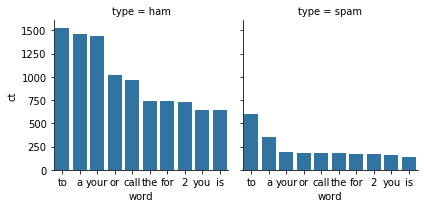

In [12]:
def get_top_x(df, x, msg_type):
    df_ = df[df['type'] == msg_type]
    return df_.sort_values('ct', ascending=False).head(x)

top_10_ham = get_top_x(df, 10, 'ham')
top_10_spam = get_top_x(df, 10, 'spam')

cond_plot = sns.FacetGrid(data=pd.concat([top_10_ham, top_10_spam]), col='type')
cond_plot.map(sns.barplot, 'word', 'ct')

From the above, we can see that the top 10 most common words amongst both classes are stop words. We can use sklearn's built-in
stop words feature to remove those from our features.